# Advanced Data Science Capstone | Sentiment analysis of financial news #

For the advanced data science capstone project, data from Kaggle will be used that contain the sentiments for financial news headlines from the perspective of a retail investor. The dataset contains two columns, "Sentiment" and "News Headline". The sentiment can be negative, neutral or positive. The data is modeles using an LSTM RNN as well as a Linear SVC. Both models are evaluated.

This notebook is split into different parts which lead through the course of the project.
1. Data investigation
2. Feature engineering
3. Model training
4. Evaluation
5. Results

In [5]:
# Import Packages
import pandas as pd

In [6]:
# Load data
data = pd.read_csv("data/alldata.csv", encoding='latin-1', names=['sentiment', 'text'])

data.shape

(4846, 2)

# 1. DATA INVESTIGATION #

### Data cleansing ###
At first, the data are checked for missing values and duplicates. Further, the data are visualized to depict their distribution and to check for any possible inferences.

In [7]:
# Packages
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [8]:
data.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [9]:
# check for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


No missing values have been detected.

In [10]:
data.describe()

,sentiment,text
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


It seems that the text-column has duplicates, lets remove the second.

In [11]:
# remove duplicates and show again
data.drop_duplicates(subset = ['text'], keep = 'first', inplace = True)
data.describe()

,sentiment,text
count,4838,4838
unique,3,4838
top,neutral,The EU Commission said earlier it had fined Th...
freq,2872,1


Now the data seems to have unique values in the text-column.

### Visualization ###

Let visualize the sentiments and the text of the dataset to get a clear understanding of what we are dealing with.

neutral     2872
positive    1362
negative     604
Name: sentiment, dtype: int64

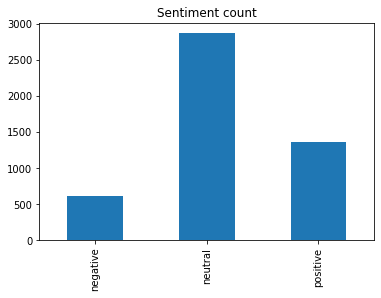

In [12]:
data.sentiment.value_counts().sort_index().plot.bar()
plt.title('Sentiment count')
data.sentiment.value_counts()

It seems the neutral sentiment occurs a lot more often than the negative and the positive. This might impair the results of our model accuracy. Let's keep it in mind and look further on the texts. First, let's check the text length of each string in the texts.

Text(0.5, 1.0, 'text length')

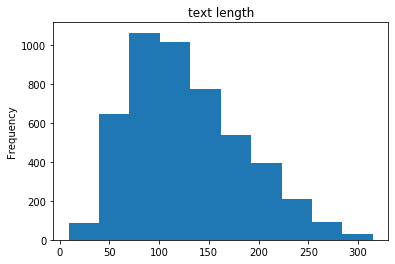

In [13]:
data.text.str.len().plot.hist()
plt.title('text length')

The distribution of the text length looks somewhat close to a gaussian distribution. Most texts vary between 100 and 150 strings. Without any outliers, the data seem fine. However, as seen below, the text is not well structured for analysis as both, lower- and uppercase letters are present as well as commas and punctuations, these should be removed for further processing. 

In [14]:
data.text.head()

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: text, dtype: object

Let's further have a look at the number of occurences of a word per sentiment ratings. This is necessary to account for any duplicates over all sentiments.

In [15]:
positive = " ".join([x for x in data.text[data.sentiment == 'positive']])
negative = " ".join([x for x in data.text[data.sentiment == 'negative']])
neutral = " ".join([x for x in data.text[data.sentiment == 'neutral']])

We create a wordcloud per sentiment 'positive', 'negative', and 'neutral'.

Text(0.5, 1.0, 'Positive')

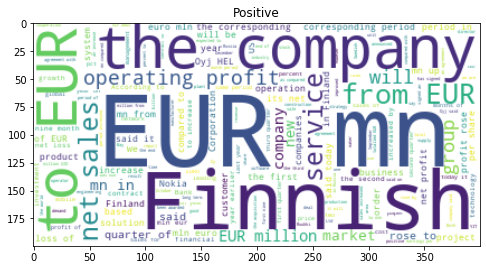

In [16]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(background_color='white').generate(positive)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Positive')

Text(0.5, 1.0, 'Negative')

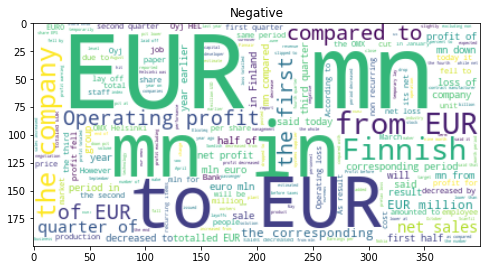

In [17]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(background_color='white').generate(negative)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Negative')

Text(0.5, 1.0, 'Neutral')

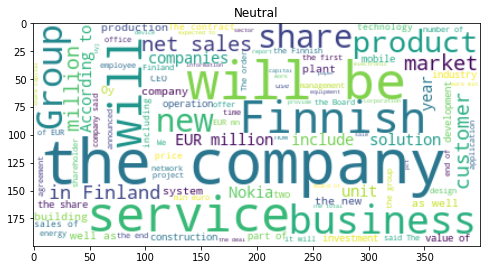

In [18]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(background_color='white').generate(neutral)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Neutral')

The words 'EUR' and 'company' seem to occur quite often in the postive and negative sentiments. Let's remove them in the next step of this data science capstone. 

# 2. FEATURE ENGINEERING #

In this step of the project, we create an ETL to remove resolve the previously found inferences in the data. Namely, the word occurences found in the wordcloud are removed, the text-strings we do not need are removed, as well as the sentiments will be one-hot-encoded to be able to feed them into an LSTM.

In [19]:
# Packages
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


At first replace the 'Eur' and 'company' of the text-column with nothing.

In [20]:
# replace with nothing
data.text = data.text.str.replace('EUR', '')
data.text = data.text.str.replace('company', '')

Now have a look at the wordclouds again and check whether they are different.

Text(0.5, 1.0, 'Neutral')

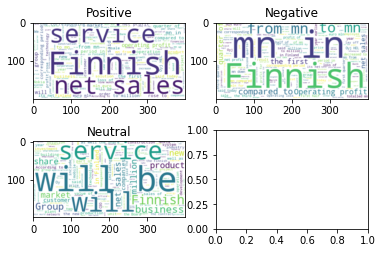

In [21]:
positive = " ".join([x for x in data.text[data.sentiment == 'positive']])
negative = " ".join([x for x in data.text[data.sentiment == 'negative']])
neutral = " ".join([x for x in data.text[data.sentiment == 'neutral']])

# plot the wordclouds together now. The workflow should be clear
fig, ax = plt.subplots(2, 2)
wordcloud = WordCloud(background_color='white').generate(positive)
ax[0, 0].imshow(wordcloud, interpolation = 'bilinear')
ax[0, 0].set_title('Positive')
wordcloud = WordCloud(background_color='white').generate(negative)
ax[0, 1].imshow(wordcloud, interpolation = 'bilinear')
ax[0, 1].set_title('Negative')
wordcloud = WordCloud(background_color='white').generate(neutral)
ax[1, 0].imshow(wordcloud, interpolation = 'bilinear')
ax[1, 0].set_title('Neutral')

Yes, this seems to be much better for analysis. Let's further transform the texts to lowercase and remove all the strings we do not need.

In [22]:
data.text.apply(lambda x: x.lower()) # transform text to lowercase
data.text = data.text.apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x)) # remove things we do not need

In [23]:
data.text.head()

0    According to Gran  the  has no plans to move a...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry  Elcoteq...
3    With the new production plant the  would incre...
4    According to the  s updated strategy for the y...
Name: text, dtype: object

This looks better.

Finally, we tokenize the text column to create numbers per words. Each text will be padded to create senteces same in length and encoded in numbers. This leaves us with a sentence length of 49

In [24]:
maxNumWords = 5000

tokenizer = Tokenizer(num_words = maxNumWords, split = " ")
tokenizer.fit_on_texts(data.text.values)

X_text = tokenizer.texts_to_sequences(data.text.values)

# all sentences have the same length, the others are filled with zeros
X_text = pad_sequences(X_text) # padding our text vector so they all have the same length
X_text[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   77,    5, 3536,    1,
          14,  220,  301,    5,  614,  110,   71,    5,  128, 2785,   26,
           9,  389,    1,    9,  706],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  792,  301,
           5,  832,    3, 1773,   31,  174,    2,  220, 1142,   90, 1774,
         648, 1775,    3,  107,    5, 3537,   80,  748,    3, 1228,  558,
           4,  707,    1,  877,   17],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
         262,  615,  127,  302,   14, 1229,  352, 3538,    2,  145,   11,
          13, 1143,  253,    5,  132,  537,    1, 2315,    1,    2,   13,
         238,  926,    1,  833,  2

In [25]:
sentence_length = X_text[0].size # number of words in a sentence
sentence_length

49

Regarding the sentiments, we one-hot-encode them by creating dummy variables.

In [26]:
y_sentiment = pd.get_dummies(data.sentiment).values
y_sentiment

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

Great. All is set for model training.

# 3. MODEL TRAINING #

In [27]:
# Packages
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

At first, we split the data into a training and test set with 20% on test data.

In [28]:
# splitting data.
x_train,x_test,y_train,y_test = train_test_split(X_text,y_sentiment, test_size = 0.2 , random_state = 0)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3870, 49), (3870, 3), (968, 49), (968, 3))

### SVC ###

The first model we train on is a Linear SVC. A Linear SVC (Support Vector Classifier) fits the data and returns a "best fit" hyperplane that divides or categorizes the data. After calculating the hyperplane, we can feed the test data to the classifier and gain the predicted classes.

Before training the model, lets refer back to the data. As we have performed a one-hot-encoding on the sentiments, we have to reverse the step on our train and test data as this structure is not suitable for a SVC. Lets have a look at the data again and write a function to reverse the structure of the one-hot-encoding.

In [29]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [30]:
def one_hot_reverse(input):
    output = []
    for i in input:
        if i[0] == 1:
            output.append(0)
        if i[1] == 1:
            output.append(1)
        if i[2] == 1:
            output.append(2)
    return output

y_train_new = one_hot_reverse(y_train)
y_test_new = one_hot_reverse(y_test)

Now, we have new train and test data of the sentiments. We will have a look at one of them to check whether their structure is correct.

In [31]:
y_train_new[:20]

[2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2]

Let's train the SVC and predict the test data.

In [32]:
svc = SVC()
svc.fit(x_train, y_train_new)
y_pred_svc = svc.predict(x_test)
y_pred_svc[0:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
print("Accuracy of SVM prediction: " + str(accuracy_score(y_test_new, y_pred_svc) * 100) )

Accuracy of SVM prediction: 61.36363636363637


The accuracy seems to be not too got but acceptable at first. Let's deploy a LSTM RNN and look whether we get better results.

### LSTM ##

In [34]:
# Packages
import tensorflow.compat.v2 as tf

In [35]:
num_layers = 256

In [36]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = maxNumWords, output_dim = num_layers,  input_length = sentence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_layers)),
    tf.keras.layers.Dense(num_layers, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax') # three outputs
])

Lets compile the model and have a look at its structure.

In [37]:
lstm_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   optimizer = tf.keras.optimizers.Adam(1e-4),
                   metrics = ['accuracy'])
lstm_model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x136d20518>>

The model is trained for 25 epochs with a batch size of 32.

In [38]:
epochs = 25
batch_size = 32

history = lstm_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

Train on 3870 samples, validate on 968 samples
Epoch 1/25
3870/3870 [==============================] - 41s 11ms/sample - loss: 0.7157 - accuracy: 0.7151 - val_loss: 0.6960 - val_accuracy: 0.7410
Epoch 2/25
3870/3870 [==============================] - 37s 9ms/sample - loss: 0.7035 - accuracy: 0.7261 - val_loss: 0.6960 - val_accuracy: 0.7410
Epoch 3/25
3870/3870 [==============================] - 35s 9ms/sample - loss: 0.7035 - accuracy: 0.7261 - val_loss: 0.6960 - val_accuracy: 0.7410
Epoch 4/25
3870/3870 [==============================] - 36s 9ms/sample - loss: 0.7030 - accuracy: 0.7265 - val_loss: 0.6915 - val_accuracy: 0.7497
Epoch 5/25
3870/3870 [==============================] - 36s 9ms/sample - loss: 0.6905 - accuracy: 0.7520 - val_loss: 0.6872 - val_accuracy: 0.7572
Epoch 6/25
3870/3870 [==============================] - 45s 12ms/sample - loss: 0.6800 - accuracy: 0.7727 - val_loss: 0.6765 - val_accuracy: 0.7793
Epoch 7/25
3870/3870 [==============================] - 42s 11ms/samp

In [39]:
lstm_model.save('lstm_model.h5')

Alright, the model is trained, saved and will be evaluated in the upcoming step. Yet, we perform an additional iteration of running the model by adjusting the feature creation performed. We As seen in the previous wordclouds, the word 'Finnish' occurs in all three sentiments. We thereby remove the word from the text in hope of increasing the model performance further.

Text(0.5, 1.0, 'Neutral')

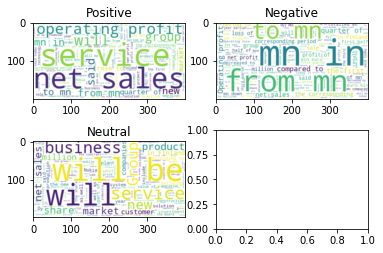

In [40]:
# delete the word finnish
data.text = data.text.str.replace('Finnish', '')

# Look at the new wordclouds
positive = " ".join([x for x in data.text[data.sentiment == 'positive']])
negative = " ".join([x for x in data.text[data.sentiment == 'negative']])
neutral = " ".join([x for x in data.text[data.sentiment == 'neutral']])

fig, ax = plt.subplots(2, 2)
wordcloud = WordCloud(background_color='white').generate(positive)
ax[0, 0].imshow(wordcloud, interpolation = 'bilinear')
ax[0, 0].set_title('Positive')
wordcloud = WordCloud(background_color='white').generate(negative)
ax[0, 1].imshow(wordcloud, interpolation = 'bilinear')
ax[0, 1].set_title('Negative')
wordcloud = WordCloud(background_color='white').generate(neutral)
ax[1, 0].imshow(wordcloud, interpolation = 'bilinear')
ax[1, 0].set_title('Neutral')

In [43]:
tokenizer = Tokenizer(num_words = maxNumWords, split = " ")
tokenizer.fit_on_texts(data.text.values)

X_text_2 = tokenizer.texts_to_sequences(data.text.values)

# all sentences have the same length, the others are filled with zeros
X_text_2 = pad_sequences(X_text_2) # padding our text vector so they all have the same length
X_text_2[:5]

sentence_length_2 = X_text_2[0].size # number of words in a sentence
print("Sentence length: " + str(sentence_length))

lstm_model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = maxNumWords, output_dim = num_layers,  input_length = sentence_length_2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_layers)),
    tf.keras.layers.Dense(num_layers, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax') # three outputs
])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_text_2, y_sentiment, test_size = 0.2 , random_state = 0)

lstm_model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   optimizer = tf.keras.optimizers.Adam(1e-4),
                   metrics = ['accuracy'])

history_2 = lstm_model_2.fit(x_train_2, y_train_2, epochs = epochs, batch_size = batch_size, validation_data = (x_test_2, y_test_2))
lstm_model_2.save('lstm_model_2-feature.h5')

Sentence length: 49
Train on 3870 samples, validate on 968 samples
Epoch 1/25
3870/3870 [==============================] - 47s 12ms/sample - loss: 0.7141 - accuracy: 0.7150 - val_loss: 0.6958 - val_accuracy: 0.7410
Epoch 2/25
3870/3870 [==============================] - 45s 12ms/sample - loss: 0.7015 - accuracy: 0.7290 - val_loss: 0.6845 - val_accuracy: 0.7669
Epoch 3/25
3870/3870 [==============================] - 45s 12ms/sample - loss: 0.6862 - accuracy: 0.7615 - val_loss: 0.6848 - val_accuracy: 0.7638
Epoch 4/25
3870/3870 [==============================] - 42s 11ms/sample - loss: 0.6824 - accuracy: 0.7686 - val_loss: 0.6815 - val_accuracy: 0.7700
Epoch 5/25
3870/3870 [==============================] - 42s 11ms/sample - loss: 0.6879 - accuracy: 0.7572 - val_loss: 0.7084 - val_accuracy: 0.7163
Epoch 6/25
3870/3870 [==============================] - 44s 11ms/sample - loss: 0.6859 - accuracy: 0.7610 - val_loss: 0.6780 - val_accuracy: 0.7772
Epoch 7/25
3870/3870 [=======================

# 4. EVALUATION #

The evaluation is done by checking the loss and the accuracy of the model.

In [44]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

### Model 1 ###

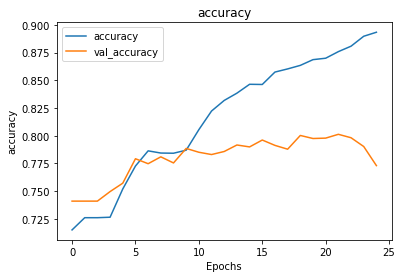

In [45]:
plot_graphs(history, 'accuracy')

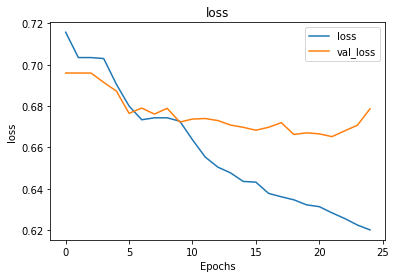

In [46]:
plot_graphs(history, 'loss')

### Model 2 ###

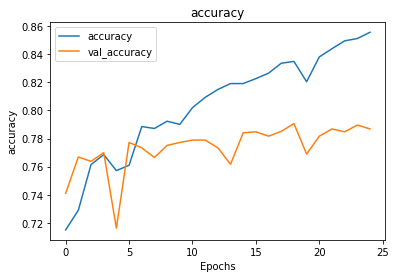

In [47]:
plot_graphs(history_2, 'accuracy')

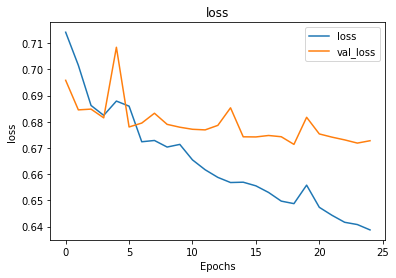

In [48]:
plot_graphs(history_2, 'loss')

Though both models perform similarly, the further analysis will be performed on model 1 as it yields a better performance.

## Evaluation and Scores of SVM and model 1 ##

In [49]:
y_pred = lstm_model.predict_classes(x_test)

In [50]:
y_array = confusion_matrix(y_test_new, y_pred)
y_array

array([[ 33,  50,  26],
       [ 63, 495,  34],
       [ 64,  94, 109]])

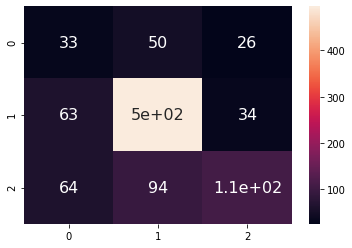

In [51]:
df_cm = pd.DataFrame(y_array, range(3), range(3))
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16}) # font size

In [66]:
score_f1_svc  = f1_score(y_test_new, y_pred_svc, average = None)
score_acc_svc = accuracy_score(y_test_new, y_pred_svc)
print("[ Neutral, Negative, Positive ]")
print("-"*50)

print("SVC")
print("F1 Score [None]  : " + str(score_f1_svc))
print("Accuracy Score: " + str(score_acc_svc))
print("-"*50)

score_f1_lstm  = f1_score(y_test_new, y_pred, average = None)
lstm_evaluation = lstm_model.evaluate(x_test, y_test)
score_acc_lstm_train = lstm_evaluation[0]
score_acc_lstm_test = lstm_evaluation[1]

print("LSTM RNN")
print("F1 Score: " + str(score_f1_lstm))
print("Accuracy Score [Train]: " + str(score_acc_lstm_train))
print("Accuracy Score [Test]: " + str(score_acc_lstm_test))

[ Neutral, Negative, Positive ]
--------------------------------------------------
SVC
F1 Score [None]  : [0.         0.75987055 0.04964539]
Accuracy Score: 0.6136363636363636
--------------------------------------------------
968/968 [==============================] - 2s 2ms/sample - loss: 0.6787 - accuracy: 0.7731
LSTM RNN
F1 Score: [0.24535316 0.80422421 0.5       ]
Accuracy Score [Train]: 0.6786680034369477
Accuracy Score [Test]: 0.77307165


# 5. RESULTS #

The results yield a better performance of the LSTM with an accuracy of around 77%, whereas the SVC prediction accuracy was around 61%. The F1 score per class depicted that the SVC was not able to predict the neutral texts.

**Overall, we can say that predicting the sentiment of financial news with an LSTM is a good fit in this use case.**